In [42]:
import json, os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

### Here's a JSON Reader Function

In [43]:
def read_axe_jsons(axe_num):
    with open('axe_listings/%s' % (axe_num), "r") as read_file:
        listing = json.load(read_file)
    with open('axe_specs/%s' % (axe_num), "r") as read_file:
        specs = json.load(read_file)
    return {'listing': listing, 'specs': specs}

### Here's a Guitar (Axe) Class with Lots of Attributes (Features)

In [44]:
class Axe:
    def __init__(self, axe_num=None):
        self.id = axe_num
        self.__body = read_axe_jsons("%s" % (axe_num))
        self.price_usd = float(self.__body['listing']['sellingStatus'][0]['convertedCurrentPrice'][0]['__value__'])
        self.title = self.__body['listing']['title'][0]
        self.market = self.__body['listing']['globalId'][0]
        self.pic = self.__body['listing']['galleryURL'][0]
        
        if self.__body['listing'].get("pictureURLLarge"):
            self.pic_big = self.__body['listing']['pictureURLLarge'][0]
        else:
            self.pic_big = None
        
        self.url = self.__body['listing']['viewItemURL'][0]
        self.autopay = self.__body['listing']['autoPay'][0] == 'true'
        self.country_seller = self.__body['listing']['country'][0]
        self.ship_type = self.__body['listing']['shippingInfo'][0]['shippingType'][0]
        self.ship_expedite = self.__body['listing']['shippingInfo'][0]['expeditedShipping'][0] == 'true'
        
        if self.__body['listing']['shippingInfo'][0].get('handlingTime'):
            self.ship_handling_time = int(self.__body['listing']['shippingInfo'][0]['handlingTime'][0])
        else: 
            self.ship_handling_time = None
        
        self.zip = self.__body['listing'].get('postalCode')
        
        self.start_time = datetime.strptime(self.__body['listing']['listingInfo'][0]['startTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        self.end_time = datetime.strptime(self.__body['listing']['listingInfo'][0]['endTime'][0], 
                                            "%Y-%m-%dT%H:%M:%S.%fZ")
        
        self.start_weekday = self.start_time.weekday()
        self.end_weekday = self.end_time.weekday()
        
        self.__duration = (self.end_time - self.start_time)
        self.duration = round(float(self.__duration.days*24) + float(self.__duration.seconds/60/60), 2)
        
        self.returns = self.__body['listing']['returnsAccepted'][0] == 'true'
        
        # End Generic Section // Begin Specs Section:
        
        if self.__body['specs'].get('Description'):
            self.description = self.__body['specs']['Description']
        else:
            self.description = None
        
        self.pic_quantity = len(self.__body['specs']['PictureURL'])
        self.seller_feedback_score = float(self.__body['specs']['Seller']['FeedbackScore'])
        self.seller_positive_percent = float(self.__body['specs']['Seller']['PositiveFeedbackPercent'])
        self.subtitle = self.__body['specs'].get('Subtitle')
        self.condition_description = self.__body['specs'].get('ConditionDescription')
        
        # Niche niche specifics:
        
        if self.returns:
            if self.__body['specs']['ReturnPolicy'].get('ReturnsWithin'):
                self.returns_time = int(self.__body['specs']['ReturnPolicy'].get('ReturnsWithin').split()[0])
        else: self.returns_time = None
            
        # Very ultra niche specifics, more ducking required:
        
        if self.__body['specs'].get('ItemSpecifics'):
            self.__attrs = {prop['Name']:prop['Value'][0] 
                            for prop in self.__body['specs']['ItemSpecifics']['NameValueList']}
            self.brand = self.__attrs.get('Brand')
            self.model = self.__attrs.get('Model')
            
            if self.__attrs.get('Model Year'):
                self.year = self.__attrs.get('Model Year')[:4]
            else: self.year = None
                
            self.material = self.__attrs.get('Body Material')
            self.right_left_hand = self.__attrs.get('Right-/ Left-Handed')
            self.country_manufacture = self.__attrs.get('Country/Region of Manufacture')
            self.body_type = self.__attrs.get('Body Type')
            self.string_config = self.__attrs.get('String Configuration')
            self.color = self.__attrs.get('Body Color')
        else:
            self.__attrs = self.brand = self.model = self.year = None
            self.material = self.right_left_hand = self.country_manufacture = None
            self.body_type = self.string_config = self.color = None    

### Loop Through All Guitar JSON Data Files, Instantiate AXE Classes

In [45]:
filenames = [name for name in os.listdir('axe_listings/') if not name.startswith('.')] # Ignore .DS_Store

In [46]:
axes = [Axe(filename) for filename in filenames]

In [47]:
len(axes)

1005

### EDA

In the API call I limited my search. 

(499 < Price < 10,000) — in USD

**Price Distribution:**

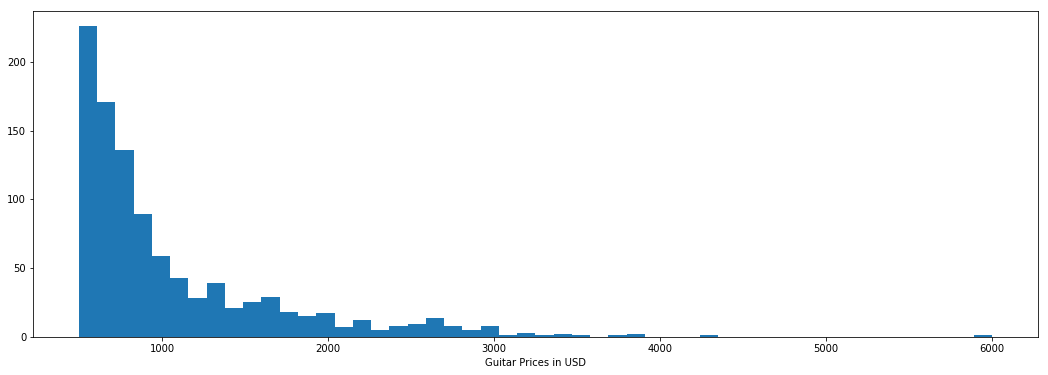

In [25]:
plt.figure(figsize = (18,6))
plt.hist([axe.price_usd for axe in axes], bins = 50)
plt.xlabel('Guitar Prices in USD')
plt.show()

__Listing Titles, for NLP:__

In [18]:
[axe.title for axe in axes]

['Gibson SG Angus Young Signature Electric Guitar',
 'Dean Baby Z Project 17612',
 'Roland GR Guitar W/ GR-700 Synthesizer',
 '1990 Jackson USA Soloist Saturn',
 'LTD Axxion Dave Mustaine Signature Electric Guitar Megadeth',
 'Gretsch Guitars G5622T Electromatic Center Block Semi-Hollow Electric Guitar ',
 'Fender 60th Anniversary Stratocaster Guitar ~ Made in USA 2014',
 'Limited Offer Price!! FENDER JAPAN ST-57 MADE IN JAPAN 1993 - 1994 RARE GOLD ',
 'Limited Offer Price!! HEARTFIELD RR-9 BY FENDER MADE IN JAPAN BY FUJIGEN 89 - 93',
 'Original Queen Brain May Guitar Red Special LE Gold and Black  sn# BHM06679',
 'Gibson Les Paul Custom',
 'EXOTIC!! GIBSON LES PAUL STANDARD PREMIUM QUILT OCEAN BLUE AQUA CUSTOM',
 'Palir guitar "Skinny Titan" tele style',
 'Ibanez RG1070PBZ Premium Series Electric Guitar w/ Case - Cerulean Blue Burst',
 'Schecter Keith Merrow KM-7 7-String Trans White Satin 235 W/Case',
 'Tokai Flying V Michael Schenker Model MIJ Electric Guitar',
 'Gibson Flying V T E

__Number of Pics on eBay listing:__

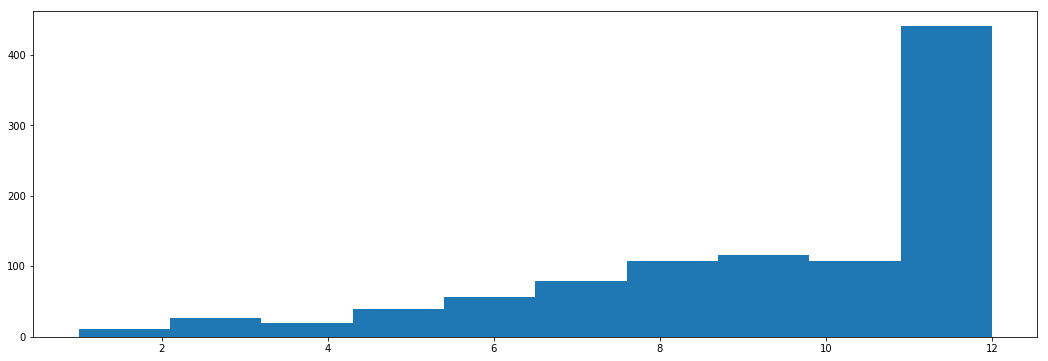

In [19]:
plt.figure(figsize = (18,6))
plt.hist([axe.pic_quantity for axe in axes])
plt.show()

__Thumbnail Image URLs__ — for Potential (CNN, maybe) Image Analysis as a factor in price

In [20]:
[axe.pic for axe in axes][:5] # Just first five. You get it

['http://thumbs1.ebaystatic.com/m/mUgbjNbqSSmOIwF_bQCd0tw/140.jpg',
 'http://thumbs4.ebaystatic.com/m/mxM1Q9pwPvqp_r48fey_pNg/140.jpg',
 'http://thumbs1.ebaystatic.com/m/mXqZUPropXPNpblOJWUS3jg/140.jpg',
 'http://thumbs1.ebaystatic.com/m/mVG9Ffkr9soQ1Gu6XNsEAbw/140.jpg',
 'http://thumbs2.ebaystatic.com/m/mV7DK2WWYr0S4sIqQWUmzZw/140.jpg']

**Shipping Type:**

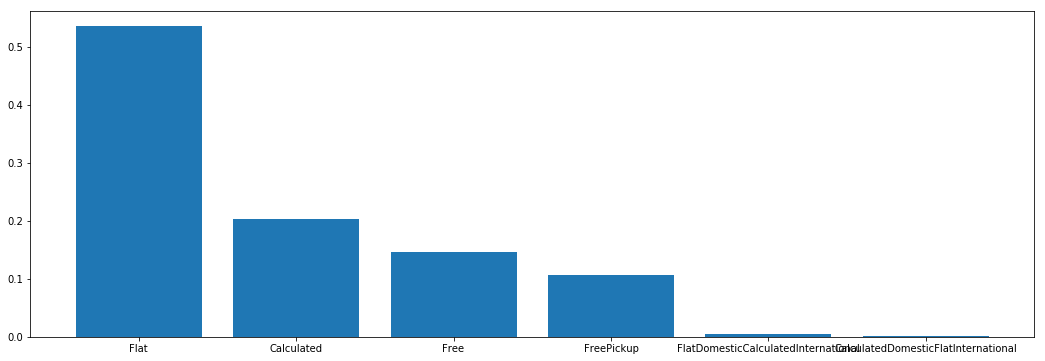

In [26]:
plt.figure(figsize = (18,6))
ship_counts = pd.Series([axe.ship_type for axe in axes]).value_counts()
plt.bar(ship_counts.index, ship_counts.values/len(axes))
plt.show()

**Handling Time in Days:**

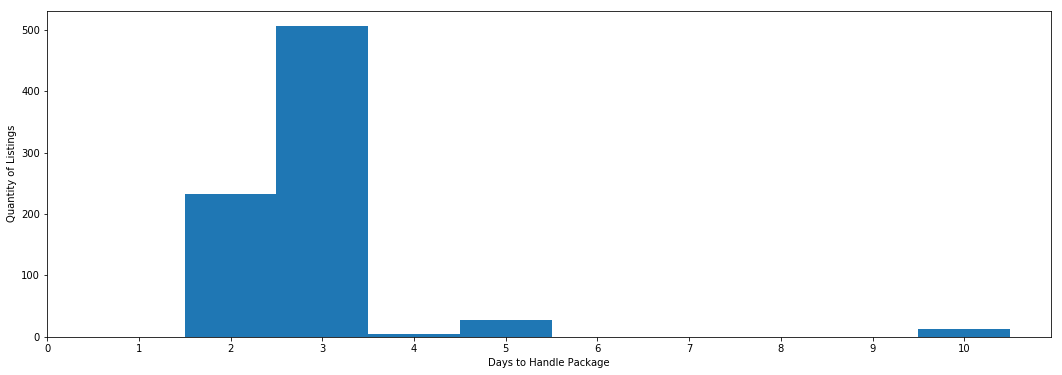

In [24]:
plt.figure(figsize = (18,6))
times = [axe.ship_handling_time for axe in axes if axe.ship_handling_time != None]
plt.hist(times, bins=np.arange(max(times))+1.5)
plt.xticks(range(11))
plt.xlabel('Days to Handle Package')
plt.ylabel('Quantity of Listings')
plt.show()

__Duration of Auction in Days__:

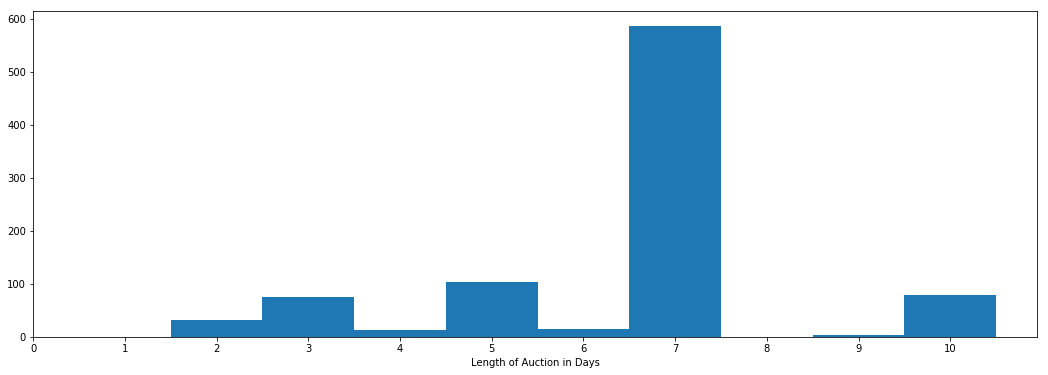

In [27]:
plt.figure(figsize = (18,6))
plt.hist([axe.duration/24 for axe in axes], bins = np.arange(10)+1.5)
plt.xticks(range(11))
plt.xlabel('Length of Auction in Days')
plt.show()

**Distribution of Countries of Sellers:**

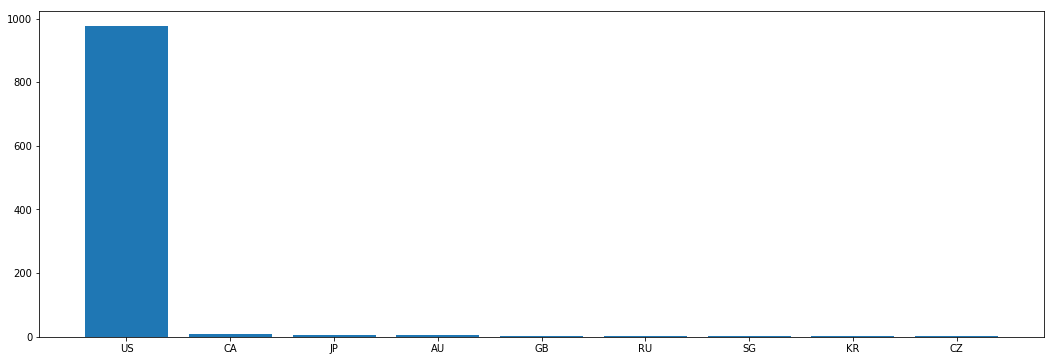

In [29]:
plt.figure(figsize = (18,6))
countries = pd.Series([axe.country_seller for axe in axes]).value_counts()
plt.bar(countries.index, countries.values)
plt.show()

Probably want to just exclude non-USA sellers.

**Offering Expedited Shipping:**

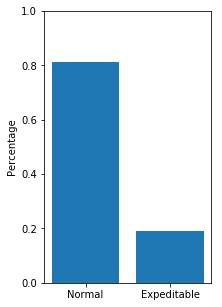

In [30]:
exp = pd.Series([axe.ship_expedite for axe in axes]).value_counts()
plt.figure(figsize = (3,5))
plt.bar(exp.index, exp.values/len(axes))
plt.xticks([False, True], ['Normal', 'Expeditable'])
plt.ylabel('Percentage')
plt.ylim(top=1)
plt.show()

**Starting Weekday:**

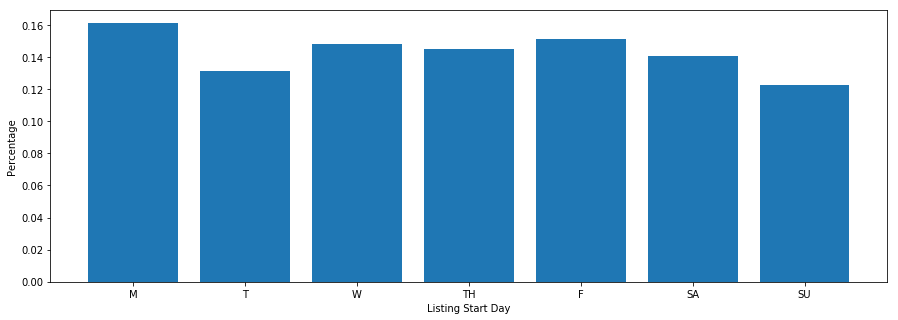

In [32]:
days = pd.Series([axe.start_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.xlabel("Listing Start Day")
plt.ylabel('Percentage')
plt.show()

**Ending Weekday:**

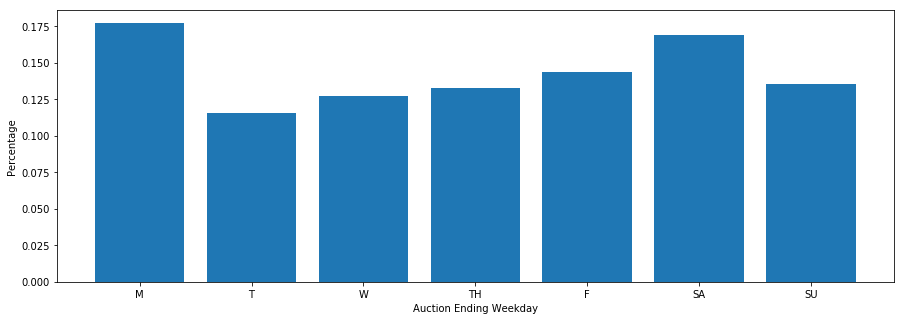

In [34]:
days = pd.Series([axe.end_weekday for axe in axes]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(days.index, days.values/len(axes))
plt.xticks(range(7), 'M T W TH F SA SU'.split(' '))
plt.ylabel('Percentage')
plt.xlabel("Auction Ending Weekday")
plt.show()

**Percentage Offering Returns:**

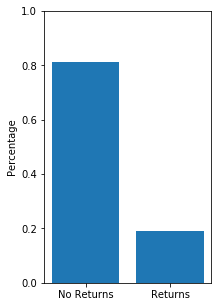

In [35]:
returns = pd.Series([axe.returns for axe in axes]).value_counts()
plt.figure(figsize = (3,5))
plt.bar(returns.index, exp.values/len(axes))
plt.xticks([False, True], ['No Returns', 'Returns'])
plt.ylabel('Percentage')
plt.ylim(top=1)
plt.show()

**Return Time Window** for those offering returns:

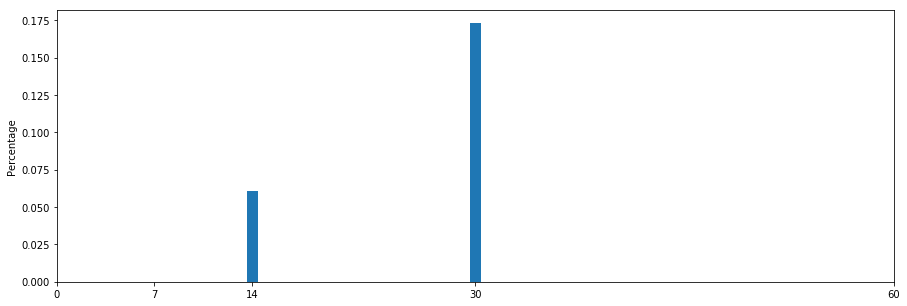

In [58]:
returns = pd.Series([axe.returns_time for axe in axes if axe.returns_time != None]).value_counts()
plt.figure(figsize = (15,5))
plt.bar(returns.index, returns.values/len(axes))
plt.xticks([0,7,14,30,60], [0,7,14,30,60])
plt.ylabel('Percentage')
plt.show()